<a href="https://colab.research.google.com/github/sallytomohno/chibi/blob/master/JWU_Univ_20200529.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 線形回帰による溶解度の予測

*キーワード*
* SMILES記法
  * 分子の化学構造をASCII符号の英数字で文字列化した、構造の曖昧性の無い表記方法である。SMILES文字列は多くの種類の分子エディタにおいてインポート可能で、二次元の図表あるいは三次元のモデルとして表示することができる。
  * 引用: https://ja.wikipedia.org/wiki/SMILES%E8%A8%98%E6%B3%95
* RDKit
  * ケモインフォマティクスのためのオープンソースのツールキット
    * ビジネスフレンドリーなBSDライセンス
    * コアデータストラクチャーとアルゴリズムはC++で記載
    * Python(2.x および3.x)のラッパーは Boost.Pythonを使って作成
    * Java と C# のラッパーはSWIGを使って作成
    * 2D と 3D で分子を取り扱えます
    * 機械学習のための記述子を生成
    * PostgreSQLのための化合物データベース・カートリッジ
    * KNIMEのためのケモインフォマティクスノード (KNIMEコミュニティサイト：https://www.knime.com/rdkit から配布されています)
    * 引用: https://www.rdkit.org/docs_jp/An_overview_of_the_RDKit_jp.html#id1
  * RDKitの使い方　https://www.rdkit.org/docs_jp/Getting_Started_with_RDKit_in_Python_jp.html
* Ridge回帰
* Lasso回帰
* Morgan フィンガープリント
  * Morgan fingerprint は最も単純な円形フラグメント記述子である(図 1)。中心原子から同心円状に 0, 1, …, p (p は半径)結合だけ離れている原子までを取り込み部分構造を作り、部分構造が何回出現するのかを数えて記述子とする。
  * 引用: https://www.jstage.jst.go.jp/article/ciqs/2019/0/2019_2A01/_pdf/-char/ja

In [0]:
# 参考: 化合物の溶解度予測 https://future-chem.com/esol-linear-model/

In [0]:
# データセット
# https://pubs.acs.org/doi/10.1021/ci034243x
# https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt
# 「ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure」
# J. Chem. Inf. Comput. Sci. 2004, 44, 1000–1005.
# (DOI: 10.1021/ci034243x)

In [0]:
# RDKitのインストール
# 参考: https://future-chem.com/rdkit-google-colab/
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!conda install -q -y -c rdkit rdkit
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-05-29 05:01:46--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-05-29 05:01:47--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ done

# All requested packages already installed.

i

In [0]:
# Google Drive の マウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
! ls "/content/drive/My Drive/Colab Notebooks/database"

 ci034243xsi20040112_053635.csv   jz7b02203_si_002.xlsx
 ci034243xsi20040112_053635.txt  'jz7b02203_si_002.xlsx - perovskite.csv'


In [0]:
# データセットの読み込み
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/database/ci034243xsi20040112_053635.csv")
df.describe()

,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L)
count,1144.000000,1144.000000
mean,-3.057997,-2.994776
std,2.096502,1.686520
min,-11.600000,-9.702000
25%,-4.332250,-3.962250
50%,-2.870500,-2.889000
75%,-1.600000,-1.846750
max,1.580000,1.091000


In [0]:
df.tail()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143,XMC,-2.581,-2.688,CNC(=O)Oc1cc(C)cc(C)c1


In [0]:
# MOLオブジェクトの構築
# 参考: https://future-chem.com/esol-linear-model/
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(frame=df, smilesCol='SMILES')

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES,ROMol
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC),
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C,
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O,
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O,
1143,XMC,-2.581,-2.688,CNC(=O)Oc1cc(C)cc(C)c1,

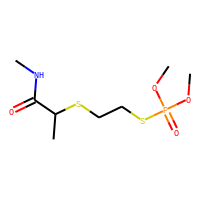
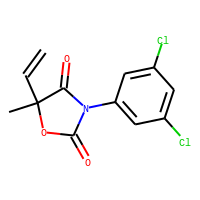
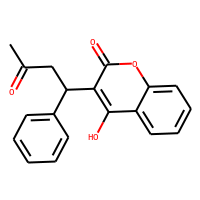
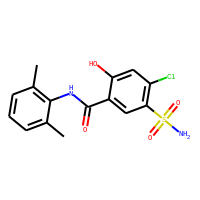
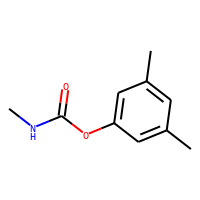

In [0]:
df.tail()

In [0]:
# 2048bitのMorganフィンガープリントの作成
from rdkit.Chem import AllChem
import numpy as np
morgan_fps = []
for mol in df.ROMol:
    fp = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
    morgan_fps.append(fp)
morgan_fps = np.array(morgan_fps) # numpy形式へ変換

In [0]:
",".join(str(x) for x in morgan_fps[0])

'0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [0]:
morgan_fps.shape

(1144, 2048)

2048 8
8
((1, 0),)
((2, 1),)
((2, 0),)
((1, 2),)
((3, 1), (4, 1), (5, 1))
((0, 1),)
((1, 1),)
((0, 0), (3, 0), (4, 0), (5, 0))


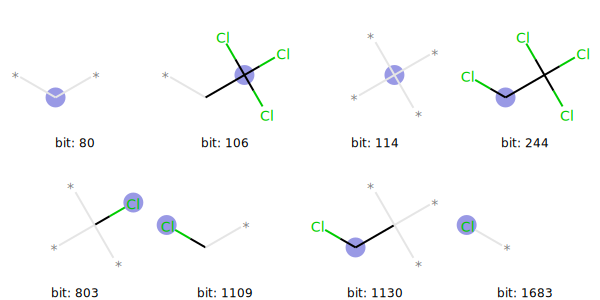

In [0]:
# Fingerprintの可視化
mol = df.ROMol[0]
## Morganフィンガープリント
bitI_morgan = {}
fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=bitI_morgan)
## Onのビットの確認
print(fp_morgan.GetNumBits(),fp_morgan.GetNumOnBits())
print(len(bitI_morgan))
## bitInfoにはビットの立っている位置と，関連する部分構造が辞書形式で格納されています
for key in bitI_morgan.keys():
    print(bitI_morgan[key])

## ビットの表示
from IPython.display import SVG
from rdkit.Chem import Draw
morgan_turples = ((mol, bit, bitI_morgan) for bit in bitI_morgan.keys())
SVG(Draw.DrawMorganBits(morgan_turples, molsPerRow=4, legends=['bit: '+str(x) for x in list(bitI_morgan.keys())]))

In [0]:
# 目的変数
target_sols = df['measured log(solubility:mol/L)']
target_sols.shape

(1144,)

In [0]:
# データセットの分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(morgan_fps, target_sols, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((858, 2048), (286, 2048), (858,), (286,))

In [0]:
import matplotlib.pyplot as plt

R2 on train: 0.983
R2 on test: -9042606456126385057431552.000


Text(0, 0.5, 'Predict')

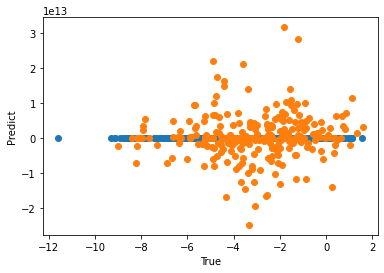

In [0]:
# 線形回帰
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print('R2 on train: {:.3f}'.format(lr.score(X_train, y_train)))
print('R2 on test: {:.3f}'.format(lr.score(X_test, y_test)))
plt.figure(figsize=(6, 5))
plt.scatter(y_train, lr.predict(X_train), label="Train")
plt.scatter(y_test, lr.predict(X_test), label="Test")
plt.xlabel("True")
plt.ylabel("Predict")
plt.legend()

R2 on train: 0.000
R2 on test: -0.000


Text(0, 0.5, 'Predict')

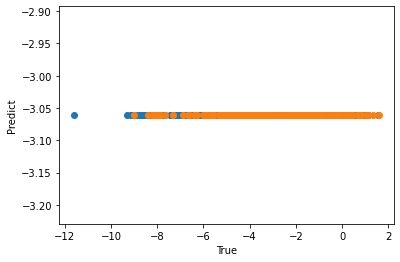

In [0]:
# Lasso回帰
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train, y_train)
print('R2 on train: {:.3f}'.format(lasso.score(X_train, y_train)))
print('R2 on test: {:.3f}'.format(lasso.score(X_test, y_test)))
plt.figure(figsize=(6, 5))
plt.scatter(y_train, lasso.predict(X_train), label="Train")
plt.scatter(y_test, lasso.predict(X_test), label="Test")
plt.xlabel("True")
plt.ylabel("Predict")
plt.legend()

In [0]:
# 正則化パラメータ αの調整
for i in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    l = Lasso(alpha=i).fit(X_train, y_train)
    print('-- Lasso: alpha = {} --'.format(i))
    print('R2 on train: {:.3f}'.format(l.score(X_train, y_train)))
    print('R2 on test: {:.3f}'.format(l.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 33.0528405083161, tolerance: 0.37756943036177154
  positive)


-- Lasso: alpha = 1e-05 --
R2 on train: 0.983
R2 on test: 0.264


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.32126426809802, tolerance: 0.37756943036177154
  positive)


-- Lasso: alpha = 0.0001 --
R2 on train: 0.980
R2 on test: 0.491
-- Lasso: alpha = 0.001 --
R2 on train: 0.932
R2 on test: 0.644
-- Lasso: alpha = 0.01 --
R2 on train: 0.706
R2 on test: 0.647
-- Lasso: alpha = 0.1 --
R2 on train: 0.228
R2 on test: 0.207
-- Lasso: alpha = 1 --
R2 on train: 0.000
R2 on test: -0.000


R2 on train: 0.706
R2 on test: 0.647


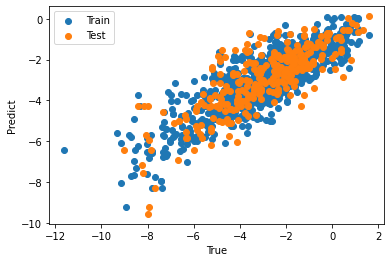

In [0]:
# Lasso回帰 (alpha = 0.01)
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01).fit(X_train, y_train)
print('R2 on train: {:.3f}'.format(lasso.score(X_train, y_train)))
print('R2 on test: {:.3f}'.format(lasso.score(X_test, y_test)))
plt.figure(figsize=(6, 5))
plt.scatter(y_train, lasso.predict(X_train), label="Train")
plt.scatter(y_test, lasso.predict(X_test), label="Test")
plt.xlabel("True")
plt.ylabel("Predict")
plt.legend()

R2 on train: 0.959
R2 on test: 0.637


Text(0, 0.5, 'Predict')

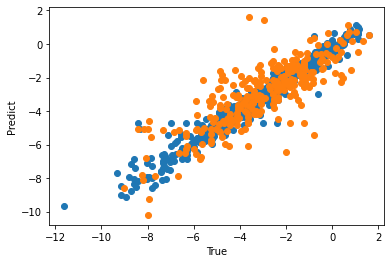

In [0]:
# Ridge回帰
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train, y_train)
print('R2 on train: {:.3f}'.format(ridge.score(X_train, y_train)))
print('R2 on test: {:.3f}'.format(ridge.score(X_test, y_test)))
plt.figure(figsize=(6, 5))
plt.scatter(y_train, ridge.predict(X_train), label="Train")
plt.scatter(y_test, ridge.predict(X_test), label="Test")
plt.xlabel("True")
plt.ylabel("Predict")
plt.legend()

In [0]:
# 正則化パラメータ αの調整
for i in [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
    l = Ridge(alpha=i).fit(X_train, y_train)
    print('-- Lasso: alpha = {} --'.format(i))
    print('R2 on train: {:.3f}'.format(l.score(X_train, y_train)))
    print('R2 on test: {:.3f}'.format(l.score(X_test, y_test)))

-- Lasso: alpha = 1e-05 --
R2 on train: 0.983
R2 on test: 0.207
-- Lasso: alpha = 0.0001 --
R2 on train: 0.983
R2 on test: 0.209
-- Lasso: alpha = 0.001 --
R2 on train: 0.983
R2 on test: 0.231
-- Lasso: alpha = 0.005 --
R2 on train: 0.983
R2 on test: 0.295
-- Lasso: alpha = 0.01 --
R2 on train: 0.983
R2 on test: 0.339
-- Lasso: alpha = 0.1 --
R2 on train: 0.981
R2 on test: 0.493
-- Lasso: alpha = 1 --
R2 on train: 0.959
R2 on test: 0.637
-- Lasso: alpha = 10 --
R2 on train: 0.859
R2 on test: 0.695
-- Lasso: alpha = 100 --
R2 on train: 0.613
R2 on test: 0.570
-- Lasso: alpha = 1000 --
R2 on train: 0.243
R2 on test: 0.234
-- Lasso: alpha = 10000 --
R2 on train: 0.041
R2 on test: 0.039


R2 on train: 0.859
R2 on test: 0.695


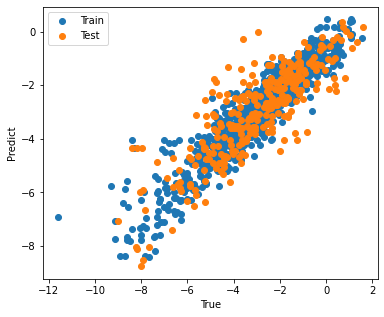

In [0]:
# Ridge回帰(alpha=10)
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=10).fit(X_train, y_train)
print('R2 on train: {:.3f}'.format(ridge.score(X_train, y_train)))
print('R2 on test: {:.3f}'.format(ridge.score(X_test, y_test)))
plt.figure(figsize=(6, 5))
plt.scatter(y_train, ridge.predict(X_train), label="Train")
plt.scatter(y_test, ridge.predict(X_test), label="Test")
plt.xlabel("True")
plt.ylabel("Predict")
plt.legend()

Text(0, 0.5, 'Coefficient')

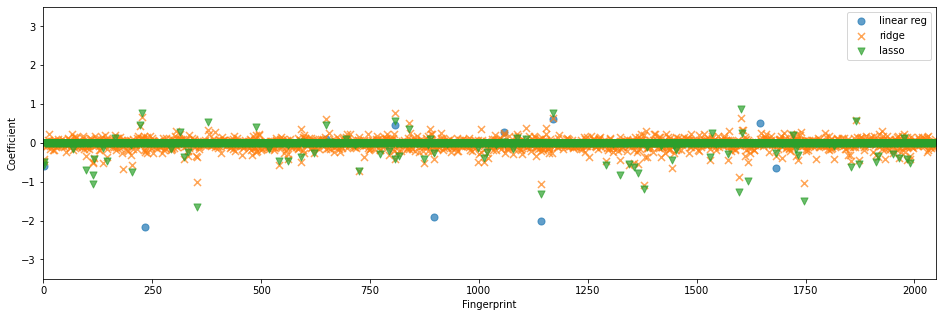

In [0]:
# 回帰分析の係数の比較
plt.figure(figsize=(16, 5))
x = range(2048)
plt.scatter(x, lr.coef_, marker='o', s=50, alpha=0.7, label='linear reg')
plt.scatter(x, ridge.coef_, marker='x', s=50, alpha=0.7, label='ridge')
plt.scatter(x, lasso.coef_, marker='v', s=50, alpha=0.7, label='lasso')
plt.legend(loc='best', frameon=True)
plt.xlim(-1,2049)
plt.ylim(-3.5, 3.5)
plt.xlabel('Fingerprint')
plt.ylabel('Coefficient')

In [0]:
# 線形回帰では過剰適合しやすいため係数が非常に大きくなる
# Ridge回帰では係数が全体的に小さく抑えられる
# Lasso回帰ではほとんどの係数がゼロになり，一部の特徴量のみがモデル構築に使われる

In [0]:
bit_coef_list = np.array(sorted(list(enumerate(lasso.coef_)), key=lambda x: abs(x[1]), reverse=True))

<BarContainer object of 20 artists>

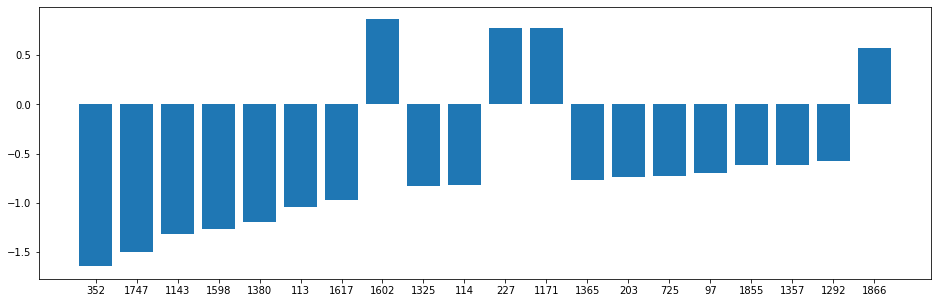

In [0]:
plt.figure(figsize=(16, 5))
plt.bar(["{:.0f}".format(x) for x in bit_coef_list[:20,0]], bit_coef_list[:20,1])

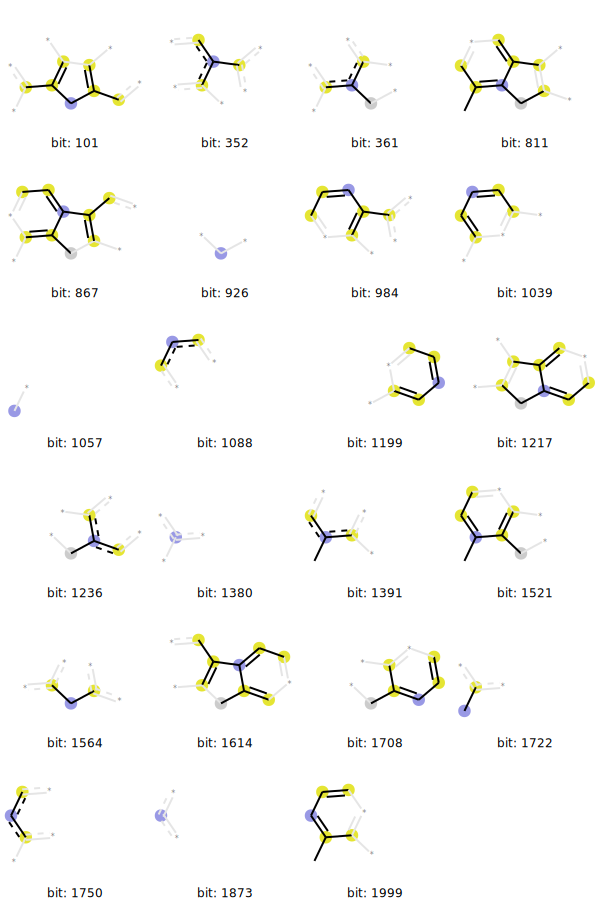

In [0]:
check_bit = 352

for mol in df.ROMol:
  ## Morganフィンガープリント
  bitI_morgan = {}
  fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=bitI_morgan)
  if fp_morgan[check_bit] == 1:
    break

## ビットの表示
from IPython.display import SVG
from rdkit.Chem import Draw
morgan_turples = ((mol, bit, bitI_morgan) for bit in bitI_morgan.keys())
SVG(Draw.DrawMorganBits(morgan_turples, molsPerRow=4, legends=['bit: '+str(x) for x in list(bitI_morgan.keys())]))

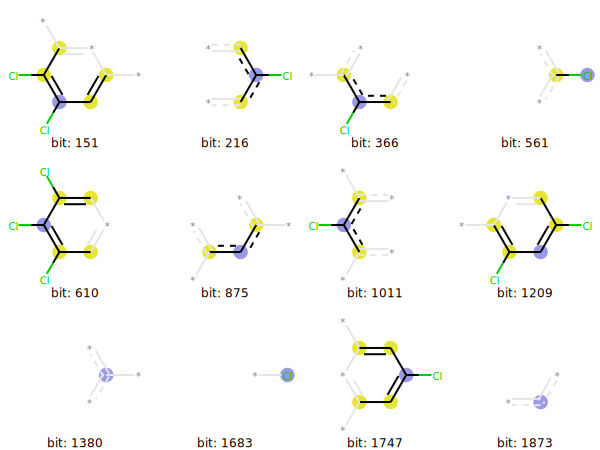

In [0]:
check_bit = 1747

for mol in df.ROMol:
  ## Morganフィンガープリント
  bitI_morgan = {}
  fp_morgan = AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048, bitInfo=bitI_morgan)
  if fp_morgan[check_bit] == 1:
    break

## ビットの表示
from IPython.display import SVG
from rdkit.Chem import Draw
morgan_turples = ((mol, bit, bitI_morgan) for bit in bitI_morgan.keys())
SVG(Draw.DrawMorganBits(morgan_turples, molsPerRow=4, legends=['bit: '+str(x) for x in list(bitI_morgan.keys())]))